In [1]:
from automl_surrogate.data.heterogeneous.dataset import HeteroPipelineDataset
from automl_surrogate.models.heterogeneous.listwise.pipelines_ranking import HeteroPipelineRankingSurrogateModel
import yaml

/home/cherniak/miniconda3/envs/gamlet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle
with open ("/home/cherniak/itmo_job/GAMLET/data/no_meta_features_and_fedot_pipelines_raw/id2pipeline_path.pickle", "rb") as f:
    id2pipe = pickle.load(f)
with open ("/home/cherniak/itmo_job/GAMLET/data/no_meta_features_and_fedot_pipelines_raw/id2dataset_id.pickle", "rb") as f:
    id2dataset = pickle.load(f)

ds = HeteroPipelineDataset(
    "/home/cherniak/itmo_job/GAMLET/data/no_meta_features_and_fedot_pipelines_raw/train_task_pipe_comb.csv",
    id2pipe,
    id2dataset,
    pipelines_per_step=100,
    use_dataset_with_id=27,
)

/home/cherniak/miniconda3/envs/gamlet/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/cherniak/miniconda3/envs/gamlet/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/cherniak/miniconda3/envs/gamlet/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The inverse_power link alias is deprecated. Use InversePower instead. The inverse_power link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/cherniak/miniconda3/envs/gamlet/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The inverse_squared link alias is deprecated. Use InverseSquared instead. The

In [3]:
with open("/home/cherniak/itmo_job/surrogate/configs/mhsa_ranking_surrogate.yml") as f:
    config = yaml.safe_load(f)
model_config = {k: v for k, v in config["model"].items() if k != "class"}

In [4]:
import torch
model = HeteroPipelineRankingSurrogateModel(**model_config)
state_dict = torch.load(
    "/home/cherniak/itmo_job/surrogate/experiment_logs/no_meta_features_and_fedot_pipelines_(type_and_hparams)/train_node_embedder_from_scratch/overfit_27th_dataset/simple_graph_encoder/rank_over_10/mhsa/version_0/checkpoints/last.ckpt",
    map_location="cpu",
)["state_dict"]
model.load_state_dict(state_dict)
model = model.eval()

In [5]:
samples = [ds[i] for i in range(128)]
batch = ds.collate_fn(samples)
x, y = batch

In [6]:
import torch

with torch.no_grad():
    pipeline_embs = model.encode_pipelines(x)

scores_all = {}
for n in [10, 20, 30, 40, 50, 60, 70, 80, 100]:
    with torch.no_grad():
        mhsa_output = model.mhsa_block(pipeline_embs[:, :n])
        scores = model.linear(mhsa_output).squeeze(2)
        scores_all[n] = scores

In [23]:
from scipy.stats import kendalltau
from sklearn.metrics import ndcg_score
from automl_surrogate.metrics import precision
import numpy as np

kt_all = {}
ndcg_all = {}
precision_all = {}
precision_at5_all = {}

for n in [10, 20, 30, 40, 50, 60, 70, 80, 100]:

    kts = []
    ndscgs = []

    for a, b in zip(y[:, :n], scores_all[n]):
        kts.append(kendalltau(a, b)[0])
        ndscgs.append(ndcg_score(a.reshape(1, -1), b.reshape(1, -1)))

    kt_all[n] = np.mean(ndscgs)
    ndcg_all[n] = np.mean(kts)
    precision_all[n] = precision(y[:, :n], scores_all[n])
    precision_at5_all[n] = precision(y[:, :n], scores_all[n], top_k=5)

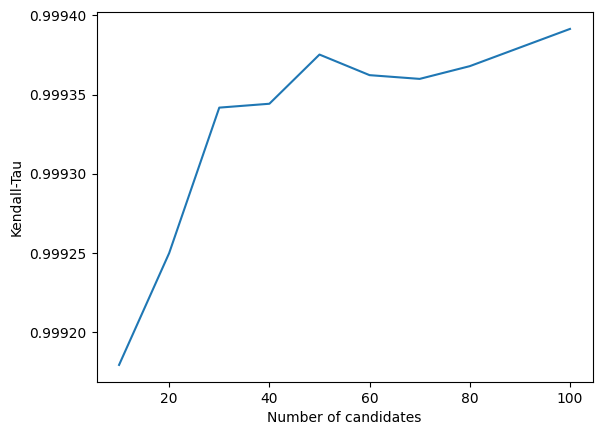

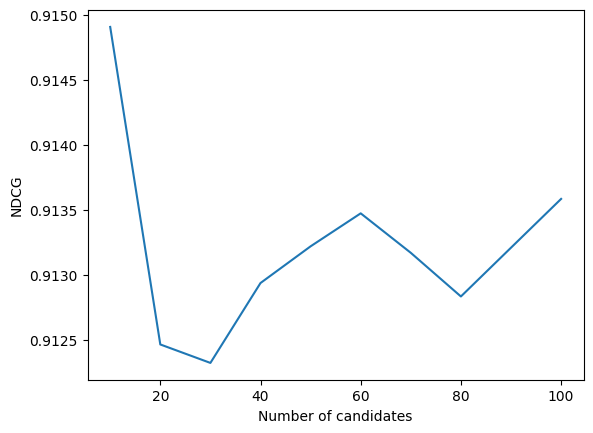

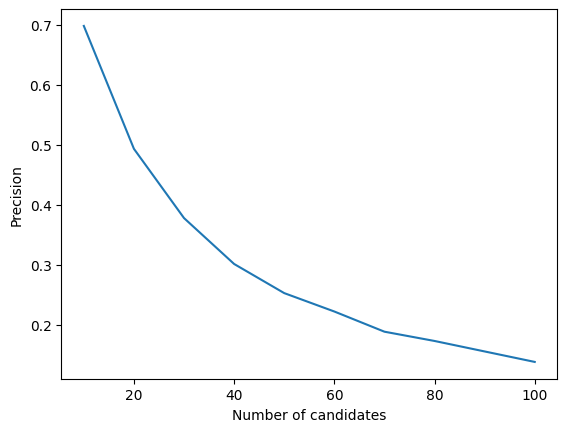

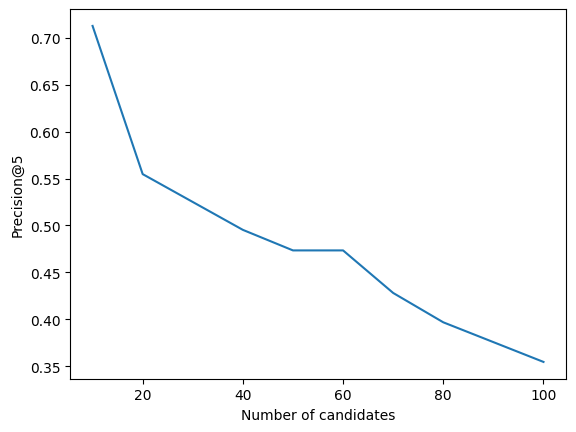

In [24]:
import matplotlib.pyplot as plt

def plot_metric(metric_data, name):
    plt.plot(metric_data.keys(), metric_data.values())
    plt.xlabel("Number of candidates")
    plt.ylabel(name)
    plt.show()

plot_metric(kt_all, "Kendall-Tau")
plot_metric(ndcg_all, "NDCG")
plot_metric(precision_all, "Precision")
plot_metric(precision_at5_all, "Precision@5")